Potato Disease Detection Implementation using Custom CNN

In [ ]:
import kagglehub

path = kagglehub.dataset_download("aarishasifkhan/plantvillage-potato-disease-dataset")
print("✅ Dataset downloaded to:", path)


100%|██████████| 37.8M/37.8M [00:00<00:00, 93.8MB/s]

Extracting files...


✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/aarishasifkhan/plantvillage-potato-disease-dataset/versions/1


In [ ]:
import os
print(os.listdir(path))


['PlantVillage']


In [ ]:
base_path = os.path.join(path, "PlantVillage")


In [ ]:
print(os.listdir(base_path))


['Potato___Late_blight', 'Potato___Early_blight', 'Potato___healthy']


In [ ]:
categories = ["Potato___Early_blight", "Potato___Late_blight", "Potato___healthy"]
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

In [ ]:
import pandas as pd

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})
df.head()


image_path                  label
0  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___Early_blight
1  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___Early_blight
2  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___Early_blight
3  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___Early_blight
4  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___Early_blight

In [ ]:
df.tail()

image_path             label
2147  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___healthy
2148  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___healthy
2149  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___healthy
2150  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___healthy
2151  /root/.cache/kagglehub/datasets/aarishasifkhan...  Potato___healthy

In [ ]:
df.shape

(2152, 2)

In [ ]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  2152 non-null   object
 1   label       2152 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB


In [ ]:
df['label'].unique()

array(['Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy'], dtype=object)

In [ ]:
df['label'].value_counts()

label
Potato___Early_blight    1000
Potato___Late_blight     1000
Potato___healthy          152
Name: count, dtype: int64

/tmp/ipython-input-15-3248606741.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


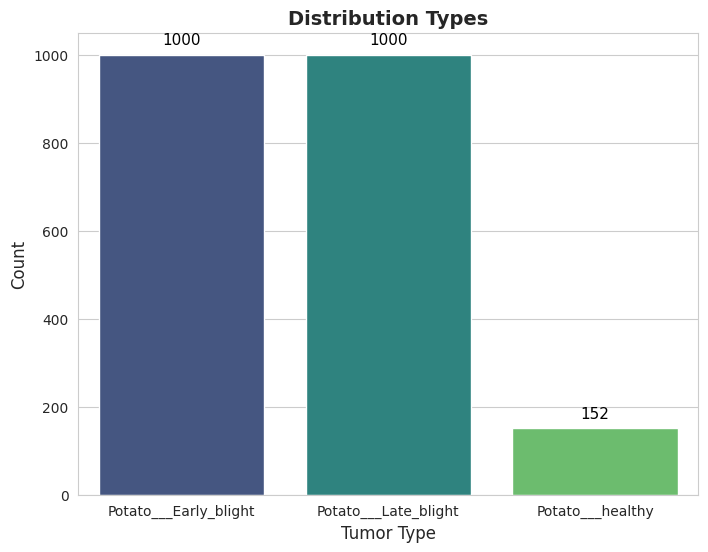

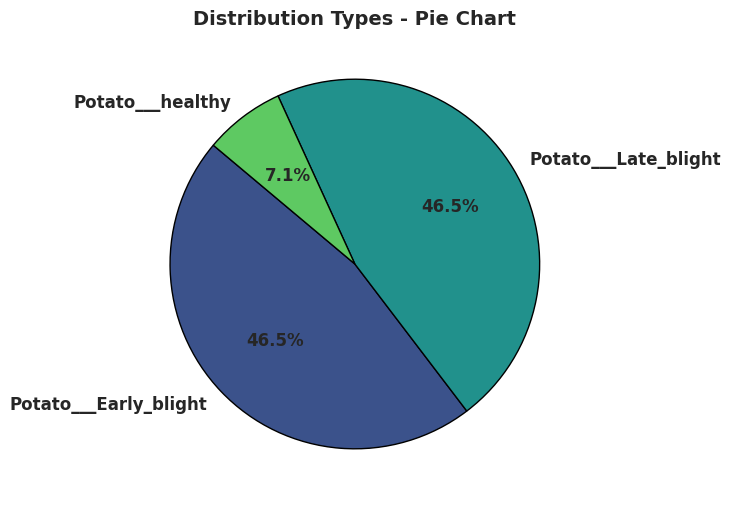

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution Types", fontsize=14, fontweight="bold")
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/ 2.,p.get_height()), ha='center', va='bottom', fontsize=11, color='black', xytext=(0,5), textcoords='offset points')
plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize = (8,6))
colors = sns.color_palette('viridis', len(label_counts))

ax.pie(label_counts,labels=label_counts.index, autopct = '%1.1f%%', startangle = 140, colors = colors, textprops ={'fontsize':12,'weight': 'bold'}, wedgeprops={'edgecolor':'black', 'linewidth': 1})

ax.set_title("Distribution Types - Pie Chart", fontsize=14, fontweight = 'bold')

plt.show()

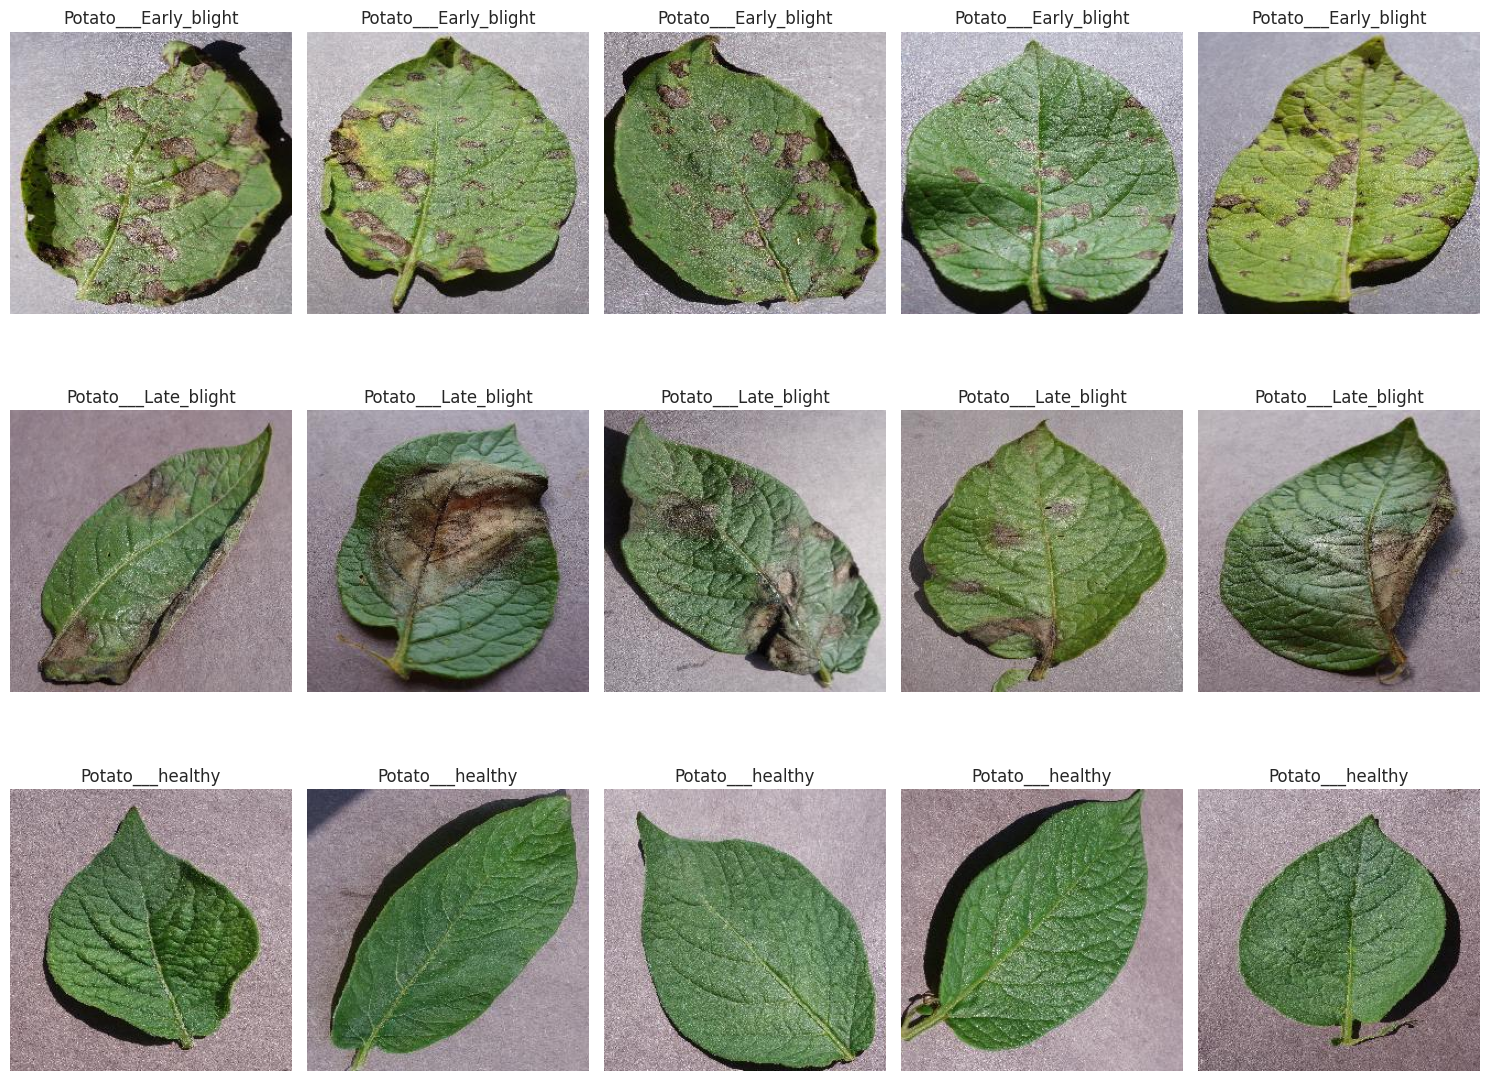

In [ ]:
import cv2

num_images = 5

plt.figure(figsize=(15,12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images,  i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]

from sklearn.utils import resample
max_count = df['category_encoded'].value_counts().max()

dfs = []
for category in df['category_encoded'].unique():
    class_subset = df[df['category_encoded'] == category]
    class_unsampled = resample(class_subset, replace=True, n_samples = max_count, random_state = 42)
    dfs.append(class_unsampled)

df_balanced = pd.concat(dfs).sample(frac = 1, random_state = 42).reset_index(drop = True)
df_balanced['category_encoded'].value_counts()

category_encoded
1    1000
0    1000
2    1000
Name: count, dtype: int64

In [ ]:
df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [ ]:
import numpy as np
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")
print("check")

check


In [ ]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size = 0.8,
    shuffle = True,
    random_state = 42,
    stratify = df_resampled['category_encoded']
)

valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size = 0.5,
    shuffle = True,
    random_state = 42,
    stratify = temp_df_new['category_encoded']
)

batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rescale = 1./255
)

ts_gen = ImageDataGenerator(rescale = 1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col = 'image_path',
    y_col = 'category_encoded',
    target_size = img_size,
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = batch_size
)

Found 2400 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.
Found 300 validated image filenames belonging to 3 classes.


In [ ]:
import tensorflow as tf
print("Number of GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Number of GPUs Available: 1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU is set for TensorFlow")
  except RuntimeError as e:
        print(e)

GPU is set for TensorFlow


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Lambda, Conv2D, MaxPooling2D,
Flatten,
                                     Dense, Reshape, Concatenate,
GlobalAveragePooling1D, Softmax, Multiply)
from tensorflow.keras.models import Model

img_size = (224, 224)
channels = 3
img_shape = (224, 224, 3)
num_classes = len(train_df_new['category_encoded'].unique())

def split_image(image):
    upper_half = image[:, :img_size[0]//2, :, :]
    lower_half = image[:, img_size[0]//2:, :, :]
    return upper_half, lower_half

def flip_lower_half(lower_half):
    return tf.image.flip_left_right(lower_half)

input_layer = Input(shape=img_shape)

upper_half, lower_half = Lambda(split_image)(input_layer)
lower_half_flipped = Lambda(flip_lower_half)(lower_half)

upper = Conv2D(32, (3, 3), activation='relu', padding='same')(upper_half)
upper = MaxPooling2D((2, 2))(upper)
upper = Conv2D(64, (3, 3), activation='relu', padding='same')(upper)
upper = MaxPooling2D((2, 2))(upper)
upper = Conv2D(128, (3, 3), activation='relu', padding='same')(upper)
upper = MaxPooling2D((2, 2))(upper)
upper = Flatten()(upper)
upper_dense = Dense(512, activation='relu')(upper)
upper_reshape = Reshape((1, 512))(upper_dense)

lower = Conv2D(32, (3, 3), activation='relu',
padding='same')(lower_half_flipped)
lower = MaxPooling2D((2, 2))(lower)
lower = Conv2D(64, (3, 3), activation='relu', padding='same')(lower)
lower = MaxPooling2D((2, 2))(lower)
lower = Conv2D(128, (3, 3), activation='relu', padding='same')(lower)
lower = MaxPooling2D((2, 2))(lower)
lower = Flatten()(lower)
lower_dense = Dense(512, activation='relu')(lower)
lower_reshape = Reshape((1, 512))(lower_dense)
concat_seq = Concatenate(axis=1)([upper_reshape, lower_reshape])
similarity_scores = tf.keras.layers.Dot(axes=-1,
normalize=True)([upper_reshape, lower_reshape])  # (None, 1, 1)
attention_weights = Softmax(axis=1)(similarity_scores)
attended = Multiply()([attention_weights, upper_reshape])
combined = Concatenate(axis=-1)([attended, lower_reshape])  #
combined = Reshape((1024,))(combined)
fc1 = Dense(256, activation='relu')(combined)
fc2 = Dense(128, activation='relu')(fc1)
output = Dense(num_classes, activation='softmax')(fc2)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 112, 224, │          0 │ input_layer[0][0] │
│                     │ 3), (None, 112,   │            │                   │
│                     │ 224, 3)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 112, 224,  │          0 │ lambda[0][1]      │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 224,  │        896 │ lambda[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 224,  │        896 │ lambda_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 112,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 112,   │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 112,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 112,   │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 56,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 14, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50176)     │          0 │ max_pooling2d_5[

 Total params: 51,863,427 (197.84 MB)

 Trainable params: 51,863,427 (197.84 MB)

 Non-trainable params: 0 (0.00 B)

Saving model plot to: /content


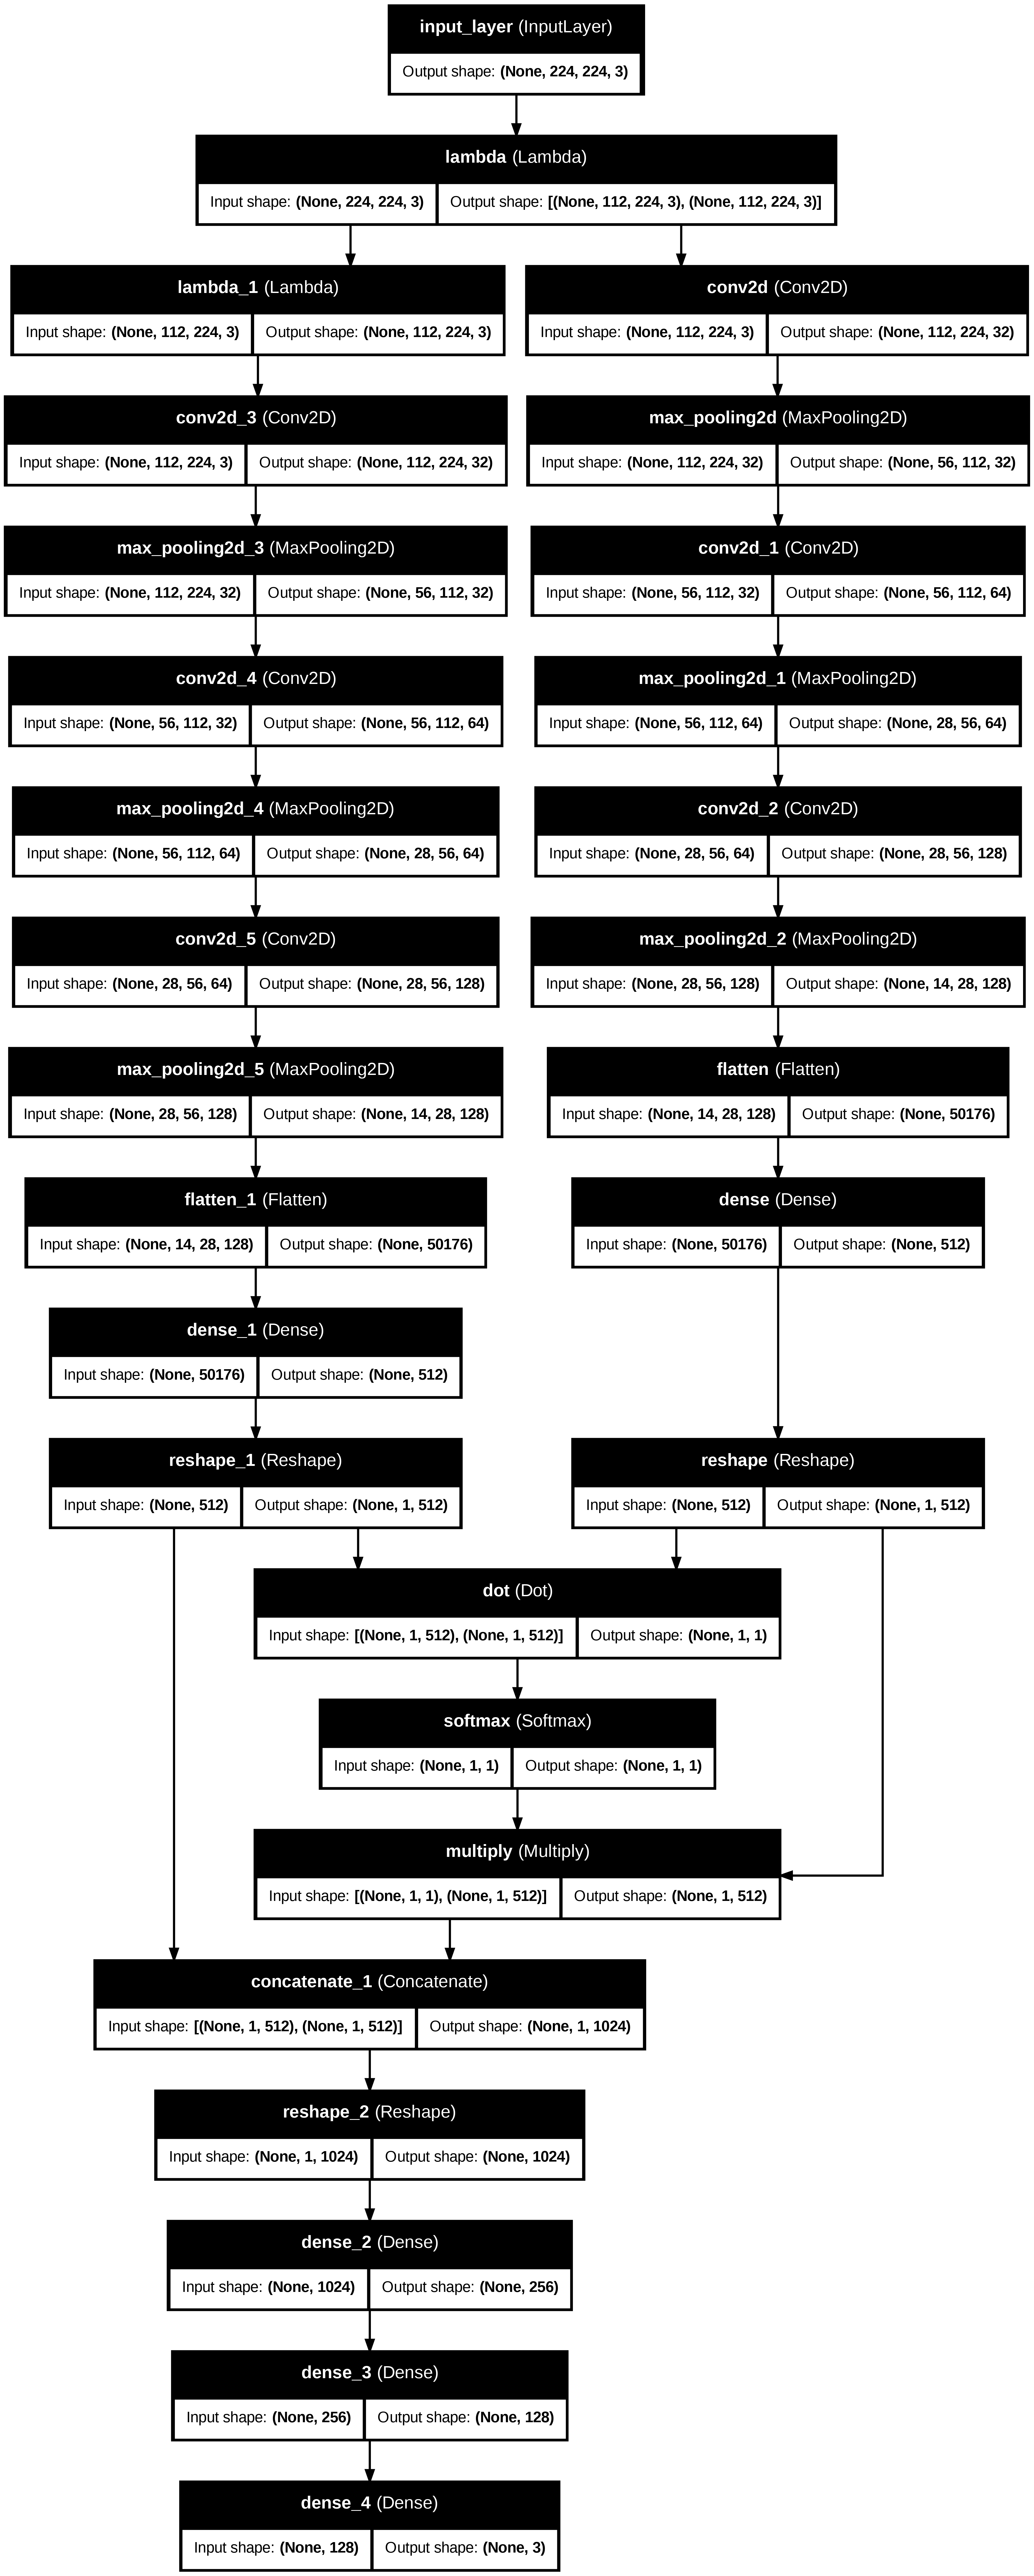

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import os

# ✅ Optional: check current directory
print("Saving model plot to:", os.getcwd())

# ✅ Plot the model architecture to an image file
plot_model(model,
           to_file='model.png',
           show_shapes=True,          # Set to True to show input/output shapes
           show_dtype=False,
           show_layer_names=True,     # Set to True to show layer names
           dpi=300)

# ✅ Display the image inline in the notebook
Image(filename='model.png')


In [ ]:
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=3,
    batch_size=batch_size
)

Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.4850 - loss: 1.2630 - val_accuracy: 0.9333 - val_loss: 0.1684
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9117 - loss: 0.2224 - val_accuracy: 0.9533 - val_loss: 0.1293
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9528 - loss: 0.1299 - val_accuracy: 0.9733 - val_loss: 0.0632


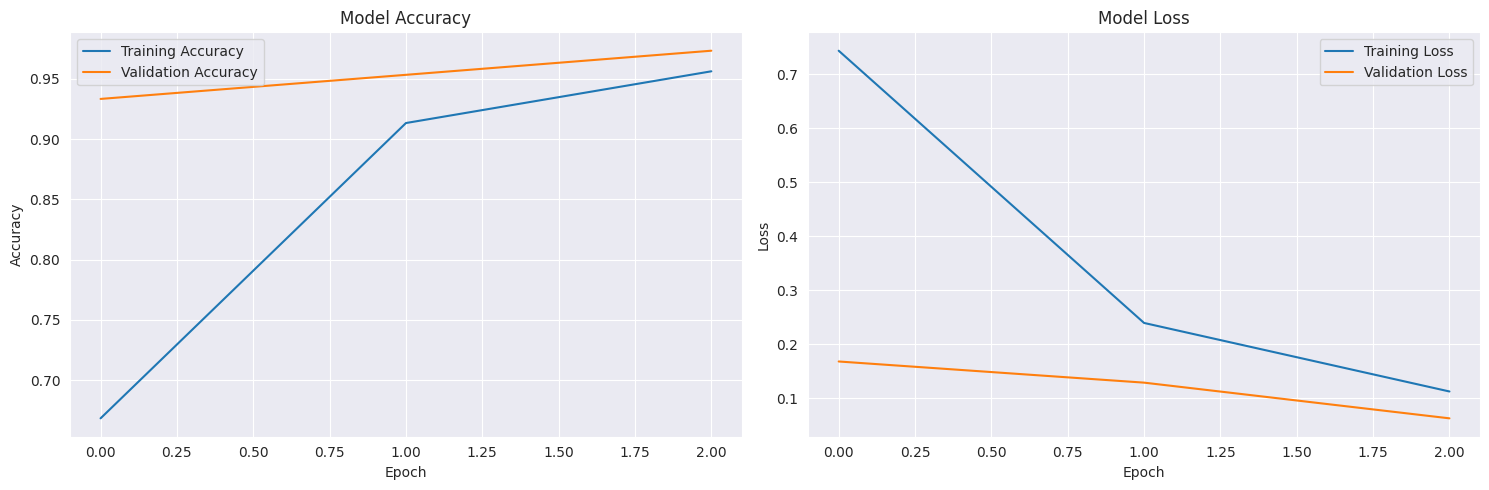

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['accuracy'], label='Training Accuracy')
  ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax1.set_title('Model Accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.legend()
  ax1.grid(True)
  ax2.plot(history.history['loss'], label='Training Loss')
  ax2.plot(history.history['val_loss'], label='Validation Loss')
  ax2.set_title('Model Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()
  ax2.grid(True)
  plt.tight_layout()
  plt.show()
plot_training_history(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9865 - loss: 0.0502
Test Accuracy: 0.9767, Test Loss: 0.0764


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
test_gen_new.reset()
y_pred = model.predict(test_gen_new)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen_new.classes

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


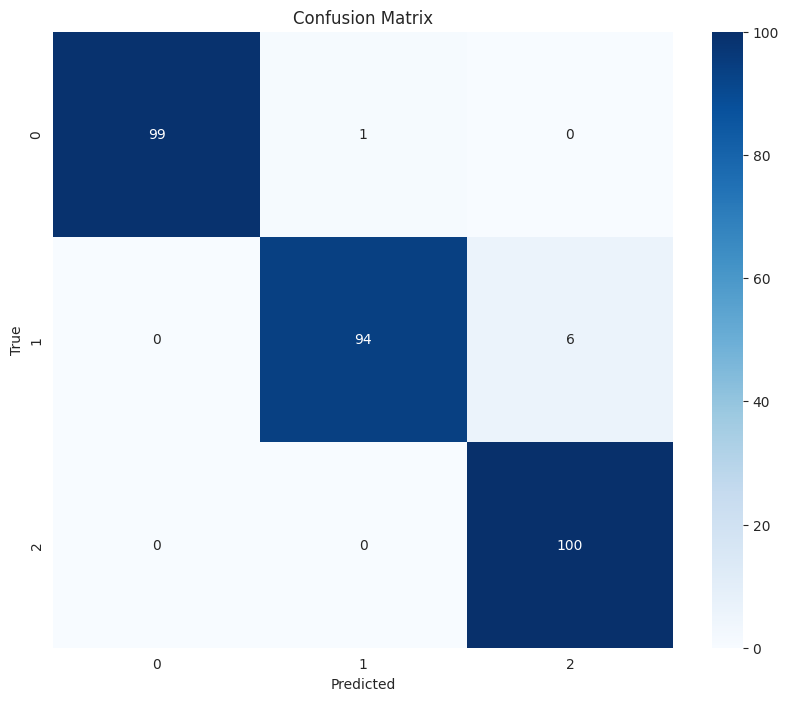

In [ ]:
class_names = list(test_gen_new.class_indices.keys())
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes,
target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       0.99      0.94      0.96       100
           2       0.94      1.00      0.97       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300

